## Investigation into how the shortest paths in network models change between update steps of a dynamic topology: Edge Weight Dynamics

In [1]:
import random 
import itertools
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt 

**Graph Creation Method**
Graph Type: Small World (Watts Strogatz)

In [2]:
# Return every adjacent pair / edge in the ring lattice 
#       structure 
# Enumerate the edges in a ring lattice of degree k 
# nodes: Range/set of nodes in ring
# k: Number of neighbours of each node 
# return: List of edges as tuples (i, j)
def ring_adjacents(nodes, k):
    hk = int(np.floor(k / 2))
    
    edges = []
    for node in nodes:
        # Identify each adjacent node 
        for j in range((node + 1), (node + hk + 1)):
            v = nodes[j % len(nodes)]  # Modulo enforces loop back to start node  
            edges.append((node, v))
    
    return edges


# Create a networkx regular ring lattice network 
# n: Number of nodes
# k: Number of neighbours of each node
# return: Regular ring lattice as networkx graph 
def ring_network(n, k):
    nodes = range(n)
    edges = ring_adjacents(nodes, k)
    
    # Create networkx graph 
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    
    return G


# Watts-Strogatz Algorithm: Randomly rewire edges of given graph
# Graph expected is a regular ring lattice n, k 
# With given probability, p, each edge is randomly assigned a new destination
# G: Graph to rewire (networkx)
# p: Probability to rewire edge
def ws_rewire(G, p):
    for i, j in G.edges():
        if random.random() < p:
            G.remove_edge(i, j)
            nodes = [n for n in list(G.nodes) if n != i  and n not in G[i]]
            # Create new edge
            u, v = i, random.choice(nodes)
            G.add_edge(u, v)

            
# Generate a networkx graph with small world properties (Watts-Strogatz)     
def watts_strogatz(n, k, p):
    # Generate the edge list of a ring lattice 
    #     of size n and degree k 
    ring = ring_network(n, k)
    
    # Randomly reassign edges with probability p
    ws_rewire(ring, p)
    
    return ring

**Edge Weight Dynamics:**  Below is the implementation of the function(s) to modify the edge weights of a given graph for one time step. 

In [3]:
# Produce an edge weight multiplier 
# In this method, a sample is drawn from a normal distribution (default mean = 1, std = 0.25)
# The values are bounded by default: [0.25, 1.75] such that the edge weight can be increased
#         or decreased by 75%
# Multipliers are bounded to avoid very large or very small edge weights
# lb: Lower bound for multiplier value
# ub: Upper bound for multiplier value 
# m: Mean of multiplier distribution 
# std: Standard deviation of multiplier distribution 
def weight_multiplier(lb = 0.25, ub = 1.75, m = 1, std = 0.2):
    sample = np.random.normal(m, std)
    
    if sample < lb:
        return lb
    if sample > ub:
        return ub
    
    return sample 

In [4]:
# Function to modify all edge weights in a graph
# Multiply each edge weight with a weight multiplier generated from normal
#    distribution 
# G: Graph to modify
# m: Mean of multiplier distribution
# std: Standard deviation of multiplier distribution
def dynamic_step_EDGE(G, m = 1, std = 0.2, pr = 1.0):
    # For each edge and weight
    for i, j, w in G.edges(data = True):
        if random.random() < pr:
            G[i][j]['weight'] = w['weight'] * weight_multiplier(m=m, std=std)

**Utility Functions (Run All):**

In [5]:
# Randomly assign edge weights in range to graph
def assign_random_weights(G, wmin, wmax, w):
    if w is None:
        for edge in G.edges():
            G[edge[0]][edge[1]]['weight'] = np.random.uniform(low=wmin, high=wmax)
    else:
        for edge in G.edges():
            G[edge[0]][edge[1]]['weight'] = w

In [6]:
# Compute the shortest paths between all pairs of nodes
# in a weighted, undirected networkx graph 
# Djiksta's algorithm 
def nx_dijkstra(G, source):
    q = []        # Queue nodes to visit in traversal 
    dist = {}     # Distances from source
    prev = {}     # Previous node in path
    
    # Initialise distances to infinity 
    for node in list(G.nodes):
        dist[node] = float('inf')
        prev[node] = None 
        q.append(node) # Queue node for visiting 
    
    dist[source] = 0
    
    while q:
        # Take the node in q with the minimum distance from source
        min_ind, du = None, float('inf')
        for ind, node in enumerate(q):
            if dist[node] < du:
                min_ind, du = ind, dist[node]
        
        # Change u from index to node value
        # Remove u from q 
        u = q.pop(min_ind)
        
        # For every neighbour of u in q
        for v in list(G[u]):
            if v not in q:
                continue 
            
            alt = dist[u] + G[u][v]['weight']
             
            # Select the shortest path to v
            if alt < dist[v]:
                dist[v] = alt
                prev[v] = u
            
    return dist, prev

In [7]:
# Function to calculate Djikstra's shortest path (distances and paths)
# between all pairs of nodes (node n is source for every node n in G)
def all_shortest_paths(G):
    distances = []
    paths = []
    
    for src in list(G.nodes):
        d, p = nx_dijkstra(G, src)
        
        distances.append(d)
        paths.append(p)
    
    return distances, paths

In [10]:
# Function to calculate the average path length 
# The is the mean of all the shortest paths between 
#     all pairs of vertices 
# The shortest paths are calculated using Djikstra's deterministic algorithm 
def average_path_length(G):
    total_length = 0.0 
    
    # For every source node 
    for src in list(G.nodes):
        # Calculate the shortest path to all other nodes 
        d, p = nx_dijkstra(G, src)
        
        # Add each path length to the total
        total_length += sum(d.values())
    
    # Shortest paths were computed for n(n-1) pairs of nodes
    # Calculate mean path length
    return (total_length / (G.number_of_nodes() * (G.number_of_nodes() - 1)))

**Dynamics of the Shortest Paths: How many paths change?**: Dynamics in the case where the initial weight of any edge (i, j) is chosen uniformly in the range 0, 100.

How do the shortest paths change between time steps where the weights are modified? 

In [11]:
# Given two Dijksta's previous-node lists from source src 
# Calculate how many of the paths between the two differ or have changed
# This is not as trivial as it first seems; for previous-node changed,
# subsequent nodes traversed via the effected node also have their
# paths changed
# Effected nodes are added to a queue and subsequent nodes identified until
# all changed paths have been accounted for 
def count_changed_paths(pt, pt_):
    paths_changed = 0
    
    effected_node_queue = [] 
    for (k, v), (k_, v_) in zip(pt.items(), pt_.items()):
        if v != v_:
            effected_node_queue.append(k_)
            
            # Look for subsequently effected nodes
            while effected_node_queue:
                paths_changed += 1 # Increment paths changed 
                n = effected_node_queue.pop(0)
                
                # For each path 
                for (q, p) in pt_.items():
                    # If the previous node in path to q is k_ 
                    if p == n:
                        # Then add q as an effected node, as its path has changed 
                        effected_node_queue.append(q)
        
    return paths_changed

In [12]:
# Calculate distnaces and paths with Dijkstra's algorithm for ts time steps 
def simulate_ts_dijkstra(G, ts, m, std, pr):
    # RECORD OUTPUT OF DIJKSTRA FOR EVERY SOURCE NODE, FOR EVERY TIME STEP 
    distances = [] # Record shortest paths distances (for each source, for each time step)
    paths = [] # Record shortest paths (for each source, for each time step)

    # For t time-steps, apply the edge weight dynamics 
    time_steps = 100
    for t in range(time_steps):
        # Calculate djikstra's for all sources 
        d, p = all_shortest_paths(G)
    
        distances.append(d)
        paths.append(p)
    
        # Perform dynamic topology modification 
        dynamic_step_EDGE(G, m = m, std = std, pr = pr)
    
    return distances, paths

In [13]:
# For ts time steps, simulate edge weight changes with m, std 
# Return a list with value for each time step giving  the count of 
# shortest paths changed 
def experiment_paths_changed(G, ts, m, std, pr):
    distances, paths = simulate_ts_dijkstra(G, ts, m, std, pr)
    
    # Every element for each dictionary key (source node) in 
    # the paths[] list represents the previous node 
    # in the path from the source to that node 
    
    # Each time a change is detected in the paths between two time steps
    # calculate how many paths are effected by this change 
    # If the previous for key N has changed, each subsequent node's path
    # has changed 
    
    # How many shortest paths changed in terms of edges in the path? 
    paths_changed = [0] # Zero paths changed at time step zero 
    for t in range(1, ts):
        pt = paths[(t-1)]
        pt_ = paths[t]
    
        # For each node-source 
        path_changed_count = 0
        for src in range(len(pt_)):
            psrc = pt[src]
            psrc_ = pt_[src]
       
            # Count the number of paths changed 
            path_changed_count += count_changed_paths(psrc, psrc_)
        
        paths_changed.append(path_changed_count)
        
    return paths_changed

In [148]:
# CHECK: For p zero, there is no change in edge weights or shortest paths (Weights aren't updated)

# Starting network: WS small-world of 250 nodes 
G = watts_strogatz(250, 10, 0.1)
# Assign edge weights uniformly chosen in range 0, 100
assign_random_weights(G, 0, 100, None)
# Run experiment 
print(experiment_paths_changed(G, ts = 100, m = 1, std = 0.1, pr = 0))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [143]:
# CHECK: For std zero, there is no change in the edge weights or shortest paths 

# Starting network: WS small-world of 250 nodes 
G = watts_strogatz(250, 10, 0.1)
# Assign edge weights uniformly chosen in range 0, 100
assign_random_weights(G, 0, 100, None)
# Run experiment 
print(experiment_paths_changed(G, ts = 100, m = 1, std = 0, pr = 1))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


**Experiment** 

It is trivial that where the edge weights in the network are changed, the shortest paths will likely be effected. 

Experiment: For parameter pr = 1 meaning that every edge in the network will be modified at each time step, is there any relationship between the standard deviation of the distribution from which the weight multipliers are drawn with the number of shortest paths changed? Is there any stability at for lower standard deviations, is there any threshold beyond which all shortest paths are changed at each time step? 

Hypothesis: That lower values of the standard deviation will correspond with fewer shortest paths changed at each time step.

In [14]:
# Probability to update edge is 1
ts, m, Pr = 100, 1, 1

# Small standard deviations in the range 0.01 - 0.1 are investigated 
STDs = [0.01, 0.05, 0.1, 0.2]

# For each STD
ex1_paths_changed = []
for std in STDs:
    # Initialise WS-Graph 
    G = watts_strogatz(250, 10, 0.1)
    assign_random_weights(G, 0, 100, None)

    # Simulate over time steps 
    results = experiment_paths_changed(G, ts = ts, m = m, std = std, pr = Pr)
    ex1_paths_changed.append(results)

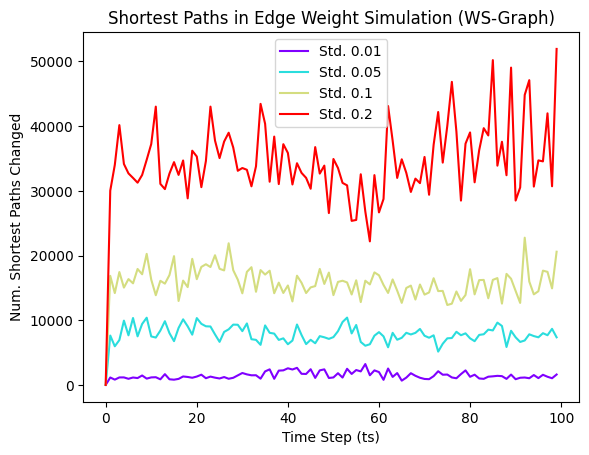

In [15]:
x = range(ts)
colours = plt.cm.rainbow(np.linspace(0, 1, len(STDs)))

fig = plt.figure()
for i in range(len(STDs)):
    plt.plot(x, ex1_paths_changed[i], color = colours[i], label = ("Std. " + str(STDs[i])))
plt.legend()
plt.xlabel("Time Step (ts)")
plt.ylabel("Num. Shortest Paths Changed")
plt.title("Shortest Paths in Edge Weight Simulation (WS-Graph)")
plt.show() 

fig.savefig('plots\ewd\ewd_ex1_paths_std.jpg')

**Experiment**

For weight multipliers drawn from a normal distribution mean = 1, std = 0.2 and bounded [0.25, 1.75], how does the probability parameter to update any given edge relate to changes in shortest paths between time steps? 

Hypothesis: The number of shortest paths changed at each time step will be proportional to the probability to apply a multiplier to each edge weight.

In [165]:
# Simulation paremeters
ts, m, std = 100, 1, 0.2

# Range of probabilities between 0, 1 are investigated
Pr_range = [0.05, 0.25, 0.5, 0.75]

# For each Probability
ex2_paths_changed = []
for Pr in Pr_range:
    # Initialise WS-Graph 
    G = watts_strogatz(250, 10, 0.1)
    assign_random_weights(G, 0, 100, None)
    
    # Simulate over time steps 
    results = experiment_paths_changed(G, ts = ts, m = m, std = std, pr = Pr)
    paths_changed.append(results)

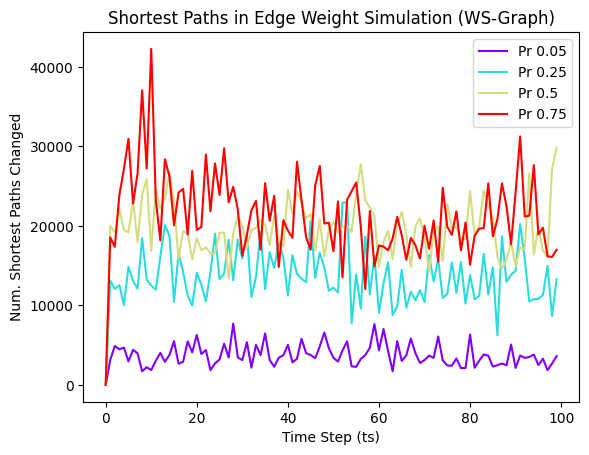

In [187]:
x = range(ts)
colours = plt.cm.rainbow(np.linspace(0, 1, len(Pr_range)))

fig = plt.figure()
for i in range(len(Pr_range)):
    plt.plot(x, ex2_paths_changed[i], color = colours[i], label = ("Pr " + str(Pr_range[i])))
plt.legend()
plt.xlabel("Time Step (ts)")
plt.ylabel("Num. Shortest Paths Changed")
plt.title("Shortest Paths in Edge Weight Simulation (WS-Graph)")
plt.show() 

fig.savefig('EW_ex1_paths_probability.jpg')

**Dynamics of the Shortest Path Lengths: How much do the paths change?**: Dynamics in the case where the initial weight of any edge (i, j) is chosen uniformly in the range 0, 100.

How do the shortest path lengths change between time steps where the weights are modified? 

**Experiment** 

For Pr to modify edge weight as 1.0 and a range of standard deviations of the edge-multiplier distribution, how is the **average shortest path length** of the graph effected? 

In [176]:
# How does the Average Shortest Path Length change between time steps? 
# How does the Standard Deviation effect the average shortest path length over time? 

# Simulation parameters
ts, m, Pr = 100, 1, 1

# Range of increasing Standard Deviations are investigated 
STDs = [0.05, 0.1, 0.2, 0.3]

ex3_avg_pathlengths = [] 
# For each std value calcualte the average shortest path length
for std in STDs:
    
    # Initialise WS-Graph 
    G = watts_strogatz(250, 10, 0.1)
    assign_random_weights(G, 0, 100, None)
    
    # Simulate over time steps 
    std_pathlengths = []
    for t in range(ts):
        # Calculate the average path length
        std_pathlengths.append(average_path_length(G))
        
        # Apply edge update
        dynamic_step_EDGE(G, m, std, Pr)
        
    avg_pathlengths.append(std_pathlengths)

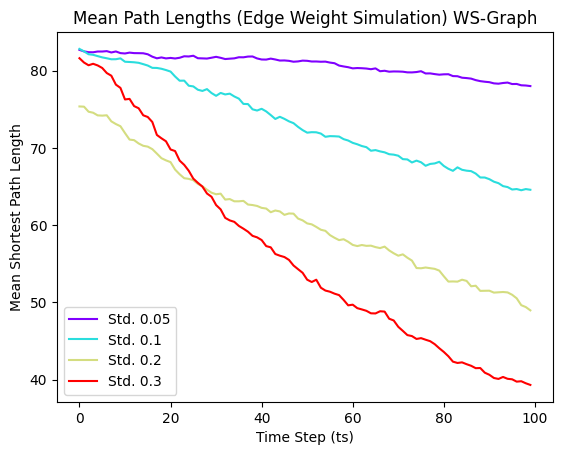

In [189]:
x = range(ts)
colours = plt.cm.rainbow(np.linspace(0, 1, len(STDs)))

fig = plt.figure()
for i in range(len(STDs)):
    plt.plot(x, ex3_avg_pathlengths[i], color = colours[i], label = ("Std. " + str(STDs[i])))
plt.legend()
plt.xlabel("Time Step (ts)")
plt.ylabel("Mean Shortest Path Length")
plt.title("Mean Path Lengths (Edge Weight Simulation) WS-Graph")
plt.show() 

fig.savefig("EW_ex3_length_std.jpg")

In [180]:
# How does the Average Shortest Path Length change between time steps? 
# How does the Standard Deviation effect the average shortest path length over time? 

# Simulation parameters
ts, m, std = 100, 1, 0.1

# Range of probabilities between 0, 1 are investigated
Pr_range = [0.05, 0.25, 0.5, 0.75]

ex4_avg_pathlengths = [] 
# For each std value calcualte the average shortest path length
for Pr in Pr_range:
    # Initialise WS-Graph 
    G = watts_strogatz(250, 10, 0.1)
    assign_random_weights(G, 0, 100, None)

    # Simulate time steps
    std_pathlengths = []
    for t in range(ts):
        # Calculate the average path length
        std_pathlengths.append(average_path_length(G))
        
        # Apply edge update
        dynamic_step_EDGE(G, m, std, Pr)
        
    avg_pathlengths.append(std_pathlengths)

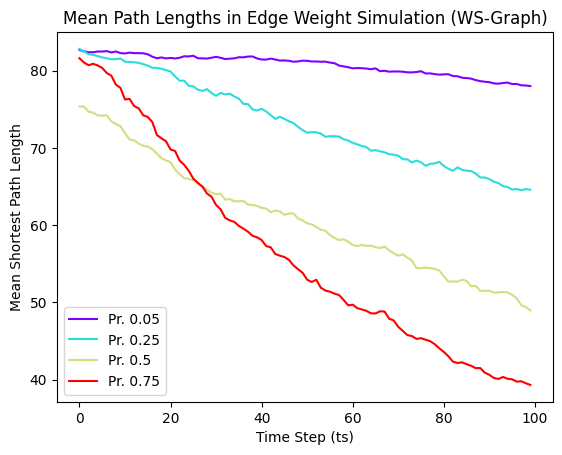

In [190]:
x = range(ts)
colours = plt.cm.rainbow(np.linspace(0, 1, len(Pr_range)))

fig = plt.figure()
for i in range(len(Pr_range)):
    plt.plot(x, ex4_avg_pathlengths[i], color = colours[i], label = ("Pr. " + str(Pr_range[i])))
plt.legend()
plt.xlabel("Time Step (ts)")
plt.ylabel("Mean Shortest Path Length")
plt.title("Mean Path Lengths in Edge Weight Simulation (WS-Graph)")
plt.show() 

fig.savefig("EW_ex4_lengths_probability.jpg")

**Edge Weight Dynamics: Random Weighting** 

In recognition that the previous method of applying a normally distributed multiplier causes the average path length to trend towards zero, which is likely to bias measures of performance of a GA over time steps, change the statistical properties of the graph and lead to a situation where all path lengths approach zero, a new method is proposed.

This method is to replace each weight with a new random sample drawn from a uniform distribution, with some probability. 

In [20]:
def dynamic_step_EDGE_2(G, Pr, minw, maxw):
    # For each edge and weight
    for i, j, w in G.edges(data = True):
        if random.random() < Pr:
            G[i][j]['weight'] = np.random.uniform(minw, maxw)

**Analysis: Random Edge Re-weighting**

In [23]:
# Calculate distnaces and paths with Dijkstra's algorithm for ts time steps 
def simulate_ts_dijkstra_2(G, ts, pr, minw, maxw):
    # RECORD OUTPUT OF DIJKSTRA FOR EVERY SOURCE NODE, FOR EVERY TIME STEP 
    distances = [] # Record shortest paths distances (for each source, for each time step)
    paths = [] # Record shortest paths (for each source, for each time step)

    # For t time-steps, apply the edge weight dynamics 
    time_steps = ts
    for t in range(time_steps):
        # Calculate djikstra's for all sources 
        d, p = all_shortest_paths(G)
    
        distances.append(d)
        paths.append(p)
    
        # Perform dynamic topology modification 
        # EDGE 2 Random Reweighting 
        dynamic_step_EDGE_2(G, pr, minw, maxw)
    
    return distances, paths

In [24]:
# For ts time steps, simulate edge weight changes with m, std 
# Return a list with value for each time step giving  the count of 
# shortest paths changed 
def experiment_paths_changed_2(G, ts, pr, minw, maxw):
    distances, paths = simulate_ts_dijkstra_2(G, ts, m, std, pr)
    
    # Every element for each dictionary key (source node) in 
    # the paths[] list represents the previous node 
    # in the path from the source to that node 
    
    # Each time a change is detected in the paths between two time steps
    # calculate how many paths are effected by this change 
    # If the previous for key N has changed, each subsequent node's path
    # has changed 
    
    # How many shortest paths changed in terms of edges in the path? 
    paths_changed = [0] # Zero paths changed at time step zero 
    for t in range(1, ts):
        pt = paths[(t-1)]
        pt_ = paths[t]
    
        # For each node-source 
        path_changed_count = 0
        for src in range(len(pt_)):
            psrc = pt[src]
            psrc_ = pt_[src]
       
            # Count the number of paths changed 
            path_changed_count += count_changed_paths(psrc, psrc_)
        
        paths_changed.append(path_changed_count)
        
    return paths_changed

In [26]:
paths_changed = []
# Simulation paremeters
ts = 100

# Range of probabilities between 0, 1 are investigated
Pr_range = [0.05, 0.25, 0.5]

# For each Probability
ex2_paths_changed = []
for Pr in Pr_range:
    # Initialise WS-Graph 
    G = watts_strogatz(250, 10, 0.1)
    assign_random_weights(G, 0, 100, None)
    
    # Simulate over time steps 
    results = experiment_paths_changed_2(G, ts, Pr, 0, 100)
    paths_changed.append(results)

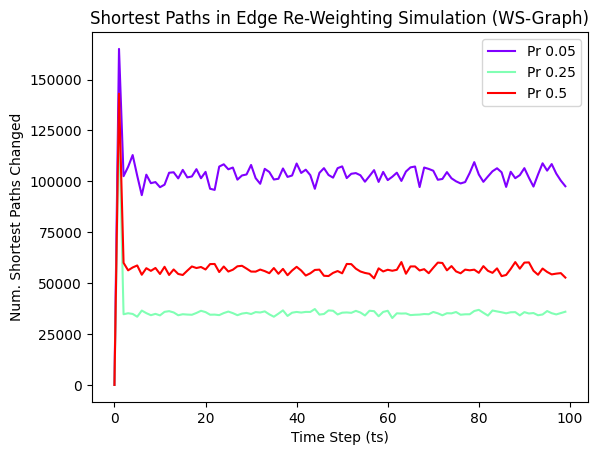

In [29]:
x = range(ts)
colours = plt.cm.rainbow(np.linspace(0, 1, len(Pr_range)))

fig = plt.figure()
for i in range(len(Pr_range)):
    plt.plot(x, paths_changed[i], color = colours[i], label = ("Pr " + str(Pr_range[i])))
plt.legend()
plt.xlabel("Time Step (ts)")
plt.ylabel("Num. Shortest Paths Changed")
plt.title("Shortest Paths in Edge Re-Weighting Simulation (WS-Graph)")
plt.show() 

fig.savefig('plots/ewd/EW2_ex1_paths.jpg')

Does the average shortest path trend towards zero? 

In [31]:
# How does the Average Shortest Path Length change between time steps? 
# How does the Standard Deviation effect the average shortest path length over time? 

# Simulation parameters
ts = 100

# Range of probabilities between 0, 1 are investigated
Pr_range = [0.05, 0.25, 0.5]

avg_pathlengths = [] 
# For each std value calcualte the average shortest path length
for Pr in Pr_range:
    # Initialise WS-Graph 
    G = watts_strogatz(250, 10, 0.1)
    assign_random_weights(G, 0, 100, None)

    # Simulate time steps
    std_pathlengths = []
    for t in range(ts):
        # Calculate the average path length
        std_pathlengths.append(average_path_length(G))
        
        # Apply edge update
        dynamic_step_EDGE_2(G, Pr, 0, 100)
        
    avg_pathlengths.append(std_pathlengths)

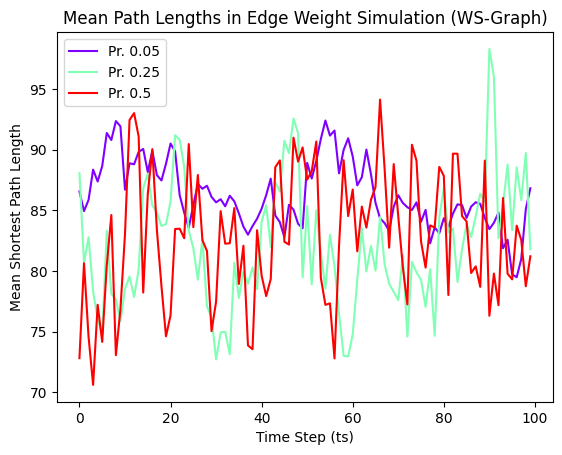

In [33]:
x = range(ts)
colours = plt.cm.rainbow(np.linspace(0, 1, len(Pr_range)))

fig = plt.figure()
for i in range(len(Pr_range)):
    plt.plot(x, avg_pathlengths[i], color = colours[i], label = ("Pr. " + str(Pr_range[i])))
plt.legend()
plt.xlabel("Time Step (ts)")
plt.ylabel("Mean Shortest Path Length")
plt.title("Mean Path Lengths in Edge Weight Simulation (WS-Graph)")
plt.show() 

fig.savefig("plots/ewd/EW2_ex2_lengths.jpg")